Ссылка на проект в colab:

https://colab.research.google.com/drive/1EE2OX1idmQ5fYczmXp5kenaGSHsePOX4?usp=sharing

## Активности  по  удержанию  клиентов  являются  важной  составляющей  развития  бизнеса.  В рамках данного pet-проекта построю модели, способные предсказать отток действующих посетителей сети ресторанов.  Предсказательный сервис основан на аналитике больших данных и машинном обучении - решение задач регрессии и классификации.
В  качестве  входных  данных  для  обучения  есть  история  покупок,  а  также
характеристики ресторанов сети.
На  выходе  сервиса  персонально  каждому  клиенту присвоена предсказанная метка класса и предсказан номер дня следующей покупки.

### Работа с трейновым датасетом

Ссылка на train:

https://drive.google.com/file/d/1ripvgNsneFhqG93hQzAZzwrl-_o6Kz2S/view?usp=sharing


In [1]:
# # для запуска в colab

# !gdown 1ripvgNsneFhqG93hQzAZzwrl-_o6Kz2S

In [2]:
# # для запуска в colab

# !unzip -o '/content/train_dataset_hackaton2023_train.zip'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#!pip install pyarrow

In [5]:
#!pip install fastparquet

In [6]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from catboost.utils import get_roc_curve
from catboost import Pool
from catboost import cv

In [8]:
df = pd.read_parquet('train_dataset_hackaton2023_train.parquet')

In [9]:
# для экономии ОЗУ

df = df.sample(frac=0.5)

### EDA

In [10]:
df.head()

,customer_id,date_diff_post,buy_post,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
11821926,20973465,11.0,1,train,139.98,2022-11-12 16:38:42,Кинг Фри мал,90.6,Фудкорт без туалета
8207740,12584726,4.0,1,train,180.00,2023-05-09 14:53:23,Мистери Гранд Чиз Фреш,297.0,Отдельно стоящий без внешней зоны
874342,909181,8.0,1,train,89.99,2022-09-29 14:54:05,Кинг Фри станд,79.7,Фудкорт с туалетом
7352524,11884944,21.0,1,train,116.49,2023-03-30 19:26:52,Наггетсы (6 шт.),100.0,Фудкорт без туалета
23067084,38986937,NaN,0,train,669.99,2023-05-16 15:00:52,Кинг Букет «Креветки»,191.4,Отдельно стоящий без туалета


In [11]:
df.drop('group_name', axis=1, inplace=True)

In [12]:
len(df)

6064692

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6064692 entries, 11821926 to 6001508
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     int64         
 1   date_diff_post  float64       
 2   buy_post        int64         
 3   revenue         float64       
 4   startdatetime   datetime64[ns]
 5   dish_name       object        
 6   ownareaall_sqm  float64       
 7   format_name     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 416.4+ MB


In [14]:
# обзор признаков типа object

for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

dish_name

Кинг Фри мал             339756
Наггетсы (3 шт.)         320181
Кинг Фри станд           229978
Соус Сырный              216703
Кинг Фри бол             183216
                          ...  
1RUB.Ангус 4 Сыра             1
Up Воппер джуниор             1
Пепси Макс XL 1л              1
Пепси Манго джун 0,3л         1
Севен Ап  мал 0,4             1
Name: dish_name, Length: 1012, dtype: int64
****************************************************************************************************

format_name

Фудкорт без туалета                              2323782
Отдельно стоящий с внешней зоной                 1155357
Отдельно стоящий без внешней зоны                 907646
Отдельно стоящий                                  832236
Фудкорт с туалетом                                583646
Отдельно стоящий без внешней зоны без туалета     134317
Отдельно стоящий без туалета                       82141
Отдельно стоящий с внешн.зоной без туалета         45554
Не заполнено          

In [15]:
df.describe()

,customer_id,date_diff_post,buy_post,revenue,ownareaall_sqm
count,6.064692e+06,4.830459e+06,6.064692e+06,6.064692e+06,6.064692e+06
mean,1.980715e+07,2.047370e+01,7.964888e-01,1.067792e+02,2.155214e+02
std,1.139137e+07,1.527044e+01,4.026095e-01,1.073527e+02,1.225760e+02
min,2.989100e+04,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.010509e+07,8.000000e+00,1.000000e+00,4.499000e+01,1.049000e+02
50%,2.127398e+07,1.700000e+01,1.000000e+00,7.998000e+01,2.104000e+02
75%,2.803722e+07,3.000000e+01,1.000000e+00,1.314200e+02,3.000000e+02
max,4.666180e+07,6.000000e+01,1.000000e+00,1.409970e+04,9.787000e+02


In [16]:
# выделяю количественные признаки

df_num_features = df.select_dtypes(include=['int64', 'float64'])

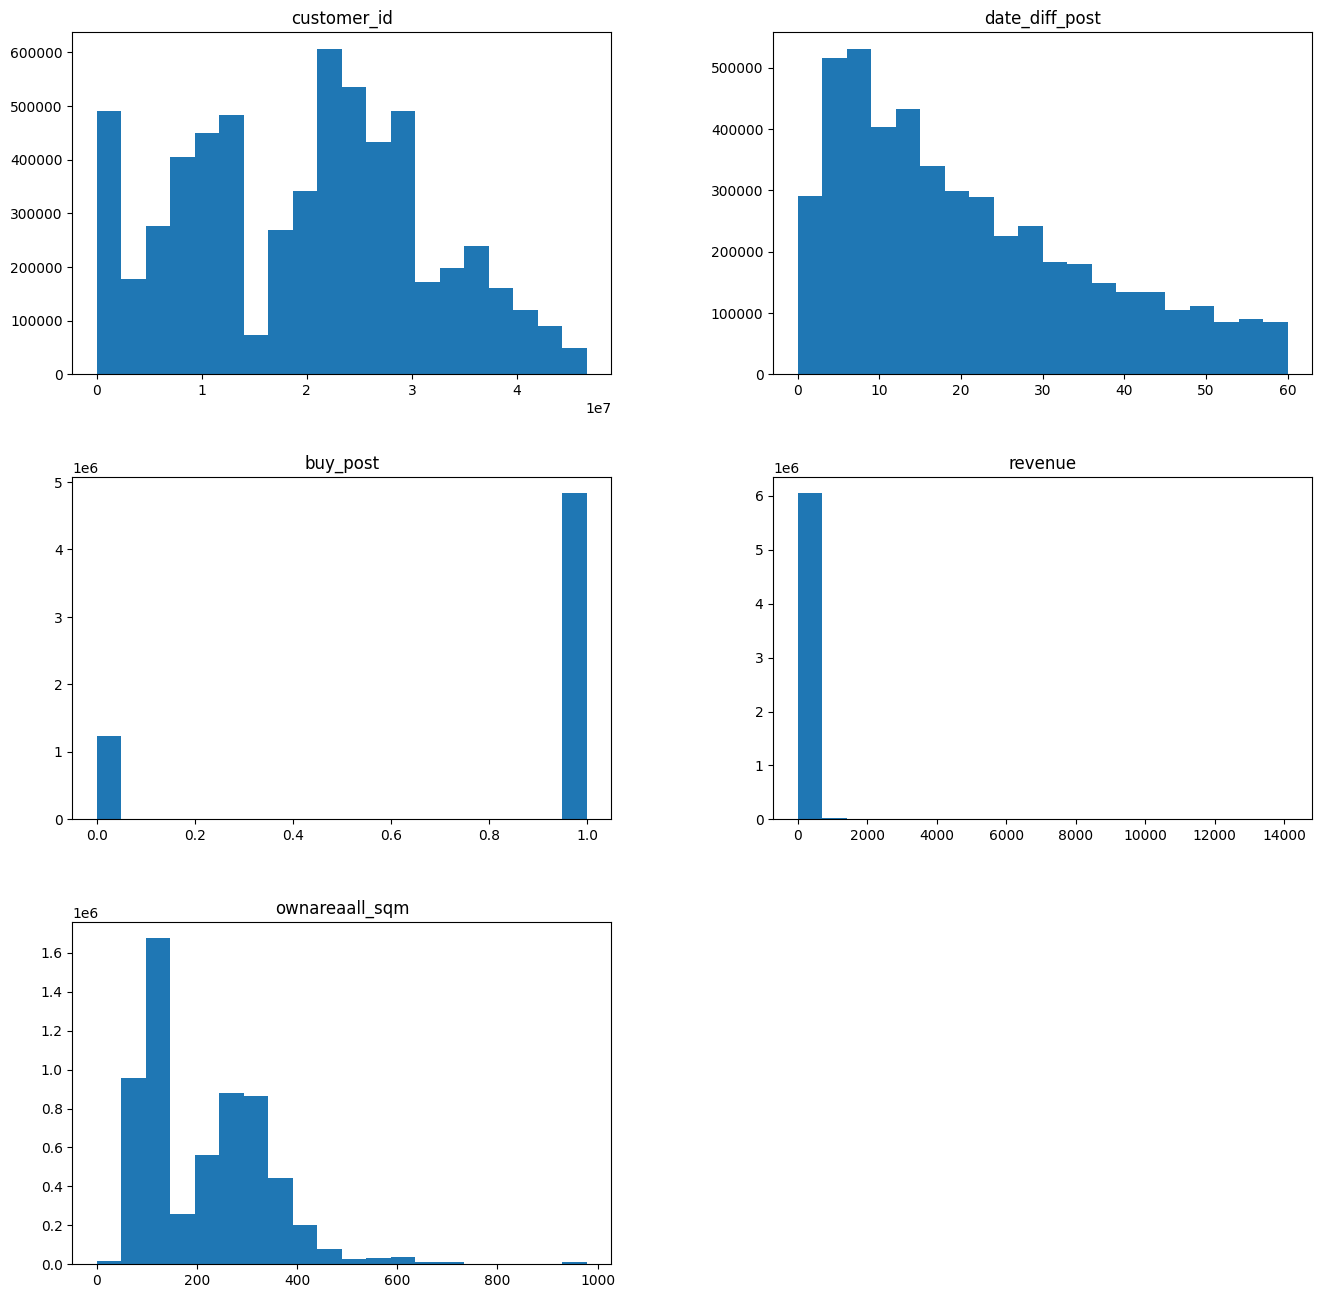

In [17]:
# изучаю гистограммы их распределения

df_num_features.hist(figsize=(16,16), bins=20, grid=False);

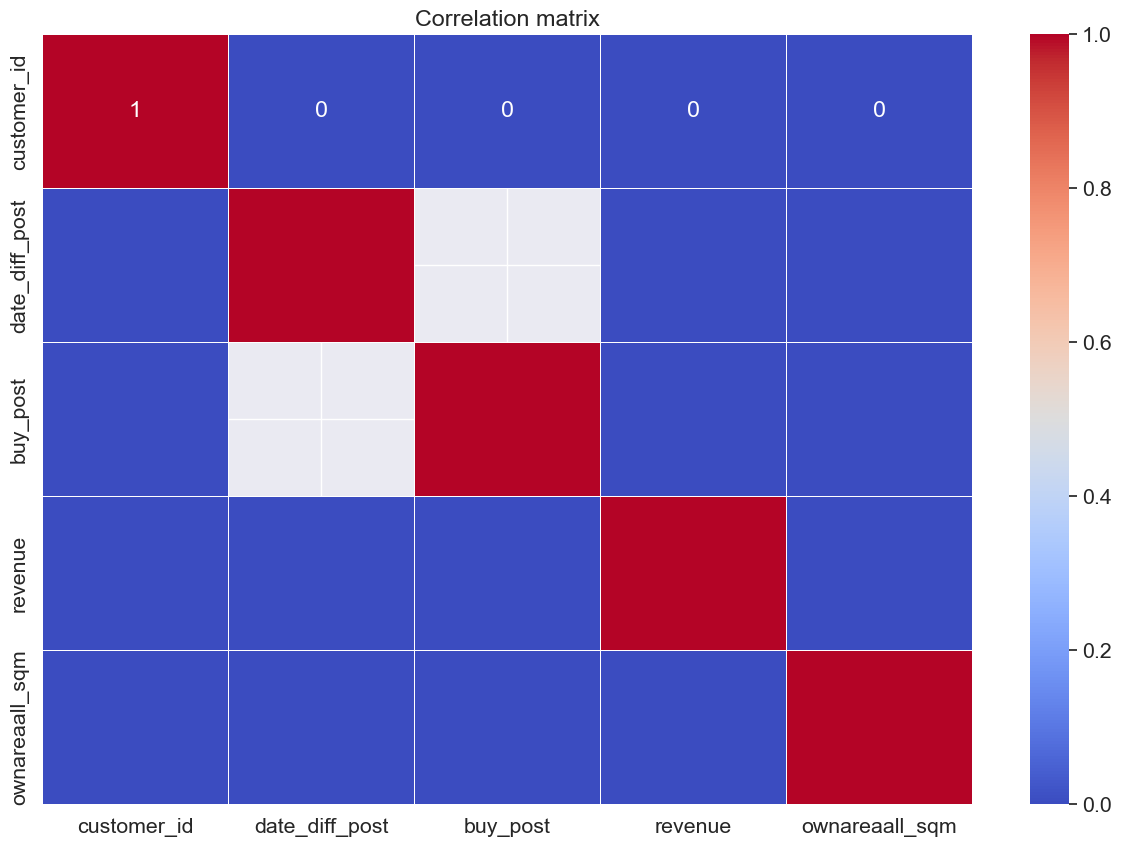

In [18]:
# оцениванию мультиколлинеарность признаков с помощью матрицы корреляций

plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [19]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        'Total (всего пропусков)': na,
        'Percent (процент пропусков)': round(100*na/df.shape[0], 3),
        'Types (тип данных)': df.dtypes
    })
    result = result[result['Total (всего пропусков)'] != 0]
    print(f'Total NA-values (всего пропусков) = {na.sum()}')
    return result.T

In [20]:
check_missings(df)

Total NA-values (всего пропусков) = 1234233


,date_diff_post
Total (всего пропусков),1234233
Percent (процент пропусков),20.351
Types (тип данных),float64


In [21]:
# количество уникальных покупателей:

df['customer_id'].nunique()

498493

1    0.796489
0    0.203511
Name: buy_post, dtype: float64


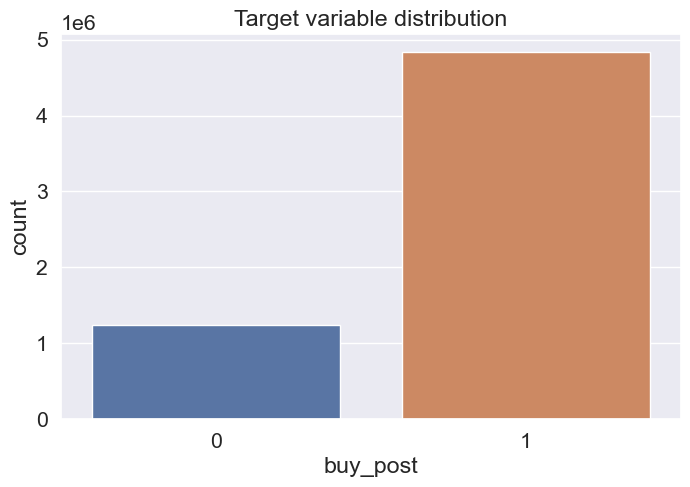

In [22]:
# смотрю распределение целевой переменной buy_post:

print(df['buy_post'].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
sns.countplot(x='buy_post', data=df)
plt.title('Target variable distribution')
plt.show()

0 если отток, 1 если НЕ отток

На лицо дисбаланс классов - применяю апсэмплинг

In [23]:
def dataset_upsampling(df, feature_name):
    """
    Функция для апсемплинга - наращивания "меньшего" класса.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных с целевой переменной.
    feature_name: str
        Имя целевой переменной.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со сбалансированным классом.

    """
    df_1 = df[df[feature_name] == 1]
    df_0  = df[df[feature_name] == 0]
    df_0_upsample = resample(df_0, replace=True, n_samples=len(df_1), random_state=42)
    df_upsampled = pd.concat([df_1, df_0_upsample])
    print(df_upsampled[feature_name].value_counts(normalize=True))
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature_name, data=df_upsampled)
    plt.title('Target variable distribution after upsampling')
    plt.show()
    return df_upsampled

In [24]:
print('Количество объектов (строк) в датафрейме ДО балансировки: ', len(df))

Количество объектов (строк) в датафрейме ДО балансировки:  6064692


1    0.5
0    0.5
Name: buy_post, dtype: float64


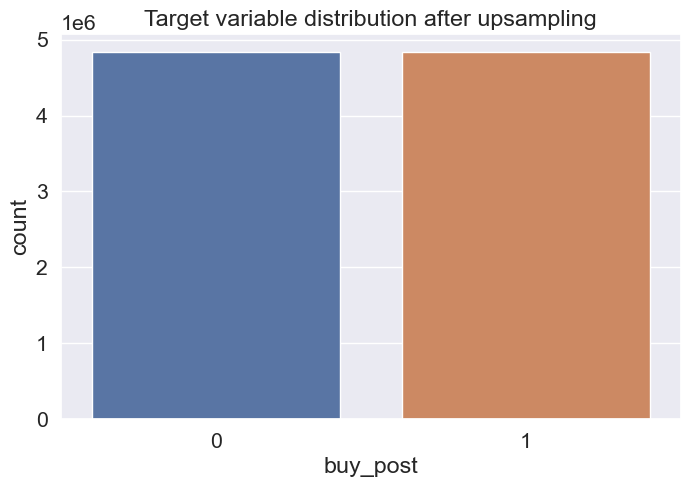

Количество объектов (строк) в датафрейме ПОСЛЕ балансировки:  9660918


In [25]:
df_upsampled = dataset_upsampling(df, 'buy_post')

print('Количество объектов (строк) в датафрейме ПОСЛЕ балансировки: ', len(df_upsampled))

In [26]:
df_upsampled.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
11821926,20973465,11.0,1,139.98,2022-11-12 16:38:42,Кинг Фри мал,90.6,Фудкорт без туалета
8207740,12584726,4.0,1,180.00,2023-05-09 14:53:23,Мистери Гранд Чиз Фреш,297.0,Отдельно стоящий без внешней зоны
874342,909181,8.0,1,89.99,2022-09-29 14:54:05,Кинг Фри станд,79.7,Фудкорт с туалетом
7352524,11884944,21.0,1,116.49,2023-03-30 19:26:52,Наггетсы (6 шт.),100.0,Фудкорт без туалета
19390289,29287560,19.0,1,104.99,2022-11-23 14:13:11,Up Кинг Наггетс Стандартный,62.1,Фудкорт без туалета


In [27]:
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9660918 entries, 11821926 to 17562926
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   customer_id     int64         
 1   date_diff_post  float64       
 2   buy_post        int64         
 3   revenue         float64       
 4   startdatetime   datetime64[ns]
 5   dish_name       object        
 6   ownareaall_sqm  float64       
 7   format_name     object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 663.4+ MB


In [28]:
df_upsampled.describe()

,customer_id,date_diff_post,buy_post,revenue,ownareaall_sqm
count,9.660918e+06,4.830459e+06,9660918.0,9.660918e+06,9.660918e+06
mean,2.044191e+07,2.047370e+01,0.5,1.092392e+02,2.148494e+02
std,1.151361e+07,1.527044e+01,0.5,1.098431e+02,1.227555e+02
min,2.989100e+04,0.000000e+00,0.0,1.000000e-02,0.000000e+00
25%,1.086380e+07,8.000000e+00,0.0,4.499000e+01,1.046700e+02
50%,2.180677e+07,1.700000e+01,0.5,7.999000e+01,2.062000e+02
75%,2.857451e+07,3.000000e+01,1.0,1.399800e+02,3.000000e+02
max,4.666180e+07,6.000000e+01,1.0,1.409970e+04,9.787000e+02


### Feature generation

In [29]:
# лояльность

counts = df_upsampled['customer_id'].value_counts()
df_upsampled['loyality'] = df_upsampled['customer_id'].apply(lambda x: counts.loc[x])

In [30]:
# производные от startdatetime

df_upsampled['datetime'] = pd.to_datetime(df_upsampled['startdatetime'], format='mixed')
df_upsampled['day_of_week'] = df_upsampled['datetime'].dt.dayofweek
df_upsampled['hour_of_day'] = df_upsampled['datetime'].dt.hour
df_upsampled['month'] = df_upsampled['datetime'].dt.month
df_upsampled['quarter'] = df_upsampled['datetime'].dt.quarter

In [31]:
# укрупняю категорию dish_name

# считаю количество вхождений каждой категории
category_counts = df_upsampled['dish_name'].value_counts()

# заменяю редкие категории на Другое
threshold = category_counts.median()  # медиана как порог отсева
for i in range(len(category_counts)):
    if category_counts[i] < threshold:
        df_upsampled['dish_name'].replace(category_counts.index[i], 'Другое', inplace=True)
len(df_upsampled['dish_name'].value_counts())

507

In [32]:
# обработка ownareaall_sqm

df_upsampled['ownareaall_sqm'].value_counts().head(50)

300.00    274049
100.00    189155
250.00    111399
400.00     70412
350.00     67401
102.00     64028
92.00      58075
80.00      56708
120.00     56239
110.00     55745
89.00      50484
320.00     45467
119.31     44155
296.00     43449
101.00     41057
367.40     39689
95.00      37538
116.00     36847
78.23      36474
200.00     36320
246.20     36104
140.00     35777
90.00      35632
128.50     34991
115.00     34750
269.90     34609
538.70     34207
113.00     34095
359.90     34041
101.80     33969
366.60     33682
244.50     32870
295.00     32805
303.00     32743
340.10     32308
233.20     31900
280.00     31772
101.60     31362
85.00      31113
260.00     30692
431.10     30197
114.50     29628
230.00     29442
98.00      29324
115.46     29223
81.00      29213
360.00     29205
361.00     28858
330.80     28777
338.90     28590
Name: ownareaall_sqm, dtype: int64

In [33]:
df_upsampled['ownareaall_sqm'].describe()

count    9.660918e+06
mean     2.148494e+02
std      1.227555e+02
min      0.000000e+00
25%      1.046700e+02
50%      2.062000e+02
75%      3.000000e+02
max      9.787000e+02
Name: ownareaall_sqm, dtype: float64

In [34]:
# функция кодирования

def fit_area(x):
    res = 0
    if x < 105:
        res = 0
    elif x < 207:
        res = 1
    elif x < 301:
        res = 2
    else:
        res = 3
    return res

In [35]:
df_upsampled['ownareaall_sqm'] = df_upsampled['ownareaall_sqm'].apply(fit_area)

In [36]:
df_upsampled['ownareaall_sqm'].value_counts()

2    2655771
0    2434646
1    2409664
3    2160837
Name: ownareaall_sqm, dtype: int64

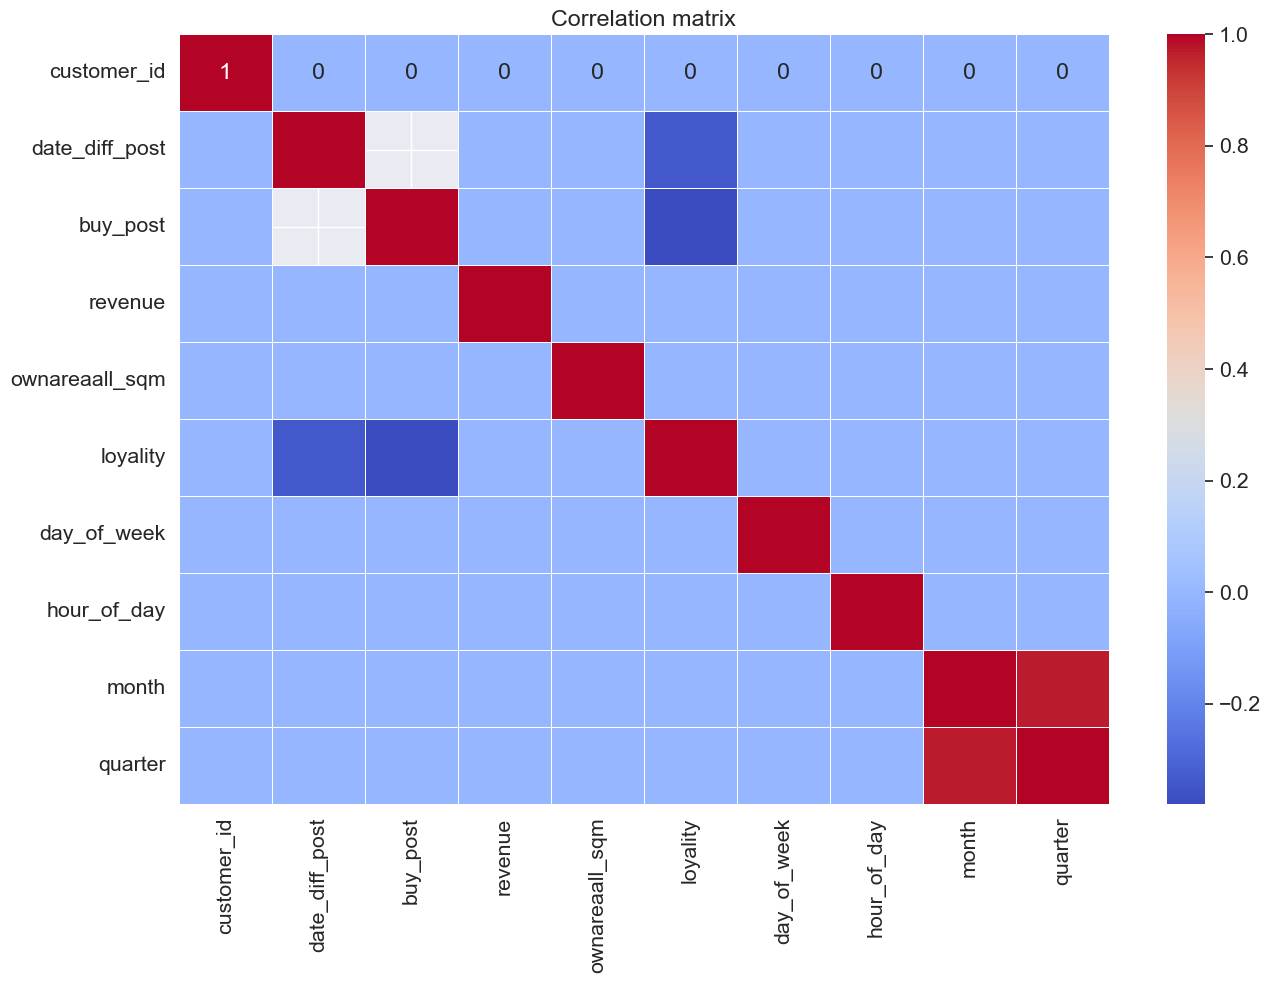

In [37]:
# оцениванию мультиколлинеарность признаков с помощью матрицы корреляций после генерации признаков

plt.figure(figsize = (15,10))
sns.set(font_scale=1.4)

corr_matrix = df_upsampled.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Регрессия: прогноз количества дней до следующей покупки

Разбиение по принципу: тест - есть пропуски, трейн - нет пропусков, чтобы спрогнозировать дни для теста

In [38]:
df_test = df_upsampled[df_upsampled['date_diff_post'].isna()]

In [39]:
df_test.drop('date_diff_post', axis=1, inplace=True)

In [40]:
df_test.head()

,customer_id,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
20458627,31487368,0,80.00,2023-06-05 11:24:25,"Сок Апельсиновый 0,2л",2,Отдельно стоящий с внешней зоной,43,2023-06-05 11:24:25,0,11,6,2
7842495,12252900,0,79.99,2022-09-14 22:02:31,Ord.Сырный и Кисло-сладкий соусы,3,Отдельно стоящий без внешней зоны,21,2022-09-14 22:02:31,2,22,9,3
3569739,6666323,0,36.00,2022-10-23 18:35:57,Наггетсы (3 шт.),2,Отдельно стоящий с внешней зоной,33,2022-10-23 18:35:57,6,18,10,4
16398510,25617849,0,119.99,2023-04-02 14:50:28,Кинг Фри бол,0,Фудкорт без туалета,31,2023-04-02 14:50:28,6,14,4,2
10152094,18346911,0,99.99,2023-01-11 18:49:21,ЧизБекон Чикен Гамбургер,1,Фудкорт с туалетом,29,2023-01-11 18:49:21,2,18,1,1


In [41]:
df = df_upsampled[~df_upsampled['date_diff_post'].isna()]

In [42]:
df.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
11821926,20973465,11.0,1,139.98,2022-11-12 16:38:42,Кинг Фри мал,0,Фудкорт без туалета,28,2022-11-12 16:38:42,5,16,11,4
8207740,12584726,4.0,1,180.00,2023-05-09 14:53:23,Мистери Гранд Чиз Фреш,2,Отдельно стоящий без внешней зоны,68,2023-05-09 14:53:23,1,14,5,2
874342,909181,8.0,1,89.99,2022-09-29 14:54:05,Кинг Фри станд,0,Фудкорт с туалетом,14,2022-09-29 14:54:05,3,14,9,3
7352524,11884944,21.0,1,116.49,2023-03-30 19:26:52,Наггетсы (6 шт.),0,Фудкорт без туалета,13,2023-03-30 19:26:52,3,19,3,1
19390289,29287560,19.0,1,104.99,2022-11-23 14:13:11,Up Кинг Наггетс Стандартный,0,Фудкорт без туалета,13,2022-11-23 14:13:11,2,14,11,4


In [43]:
len(df) + len(df_test) == len(df_upsampled)

True

In [44]:
train, test = train_test_split(df, train_size=0.6, random_state=42)

In [45]:
val, test = train_test_split(test, train_size=0.5, random_state=42)

In [46]:
train.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'revenue', 'startdatetime',
       'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'datetime',
       'day_of_week', 'hour_of_day', 'month', 'quarter'],
      dtype='object')

In [47]:
X = ['revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 
     'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post

y = ['date_diff_post'] # целевая переменная

cat_features = ['dish_name', 'format_name', 'ownareaall_sqm', 
                'day_of_week', 'hour_of_day', 'month', 'quarter'] # категориальные признаки

In [48]:
parameters = {
             'cat_features': cat_features,
             'eval_metric': 'RMSE', # метрика RMSE для задачи регрессии
             'task_type': 'GPU',
             'random_seed': 42,
             'verbose': 100
              }

In [49]:
from catboost import CatBoostRegressor

In [50]:
model_rgr = CatBoostRegressor(**parameters)

In [51]:
model_rgr.fit(train[X], train[y], eval_set=(val[X], val[y]))

Learning rate set to 0.1469
0:	learn: 14.9585815	test: 14.9468576	best: 14.9468576 (0)	total: 694ms	remaining: 11m 33s
100:	learn: 13.9222482	test: 13.9048784	best: 13.9048784 (100)	total: 40.7s	remaining: 6m 2s
200:	learn: 13.9012736	test: 13.8839071	best: 13.8839071 (200)	total: 1m 20s	remaining: 5m 19s
300:	learn: 13.8887316	test: 13.8721602	best: 13.8721602 (300)	total: 1m 59s	remaining: 4m 38s
400:	learn: 13.8782086	test: 13.8630109	best: 13.8630109 (400)	total: 2m 38s	remaining: 3m 57s
500:	learn: 13.8694729	test: 13.8556995	best: 13.8556995 (500)	total: 3m 20s	remaining: 3m 19s
600:	learn: 13.8605334	test: 13.8482454	best: 13.8482454 (600)	total: 4m	remaining: 2m 39s
700:	learn: 13.8528777	test: 13.8430182	best: 13.8430182 (700)	total: 4m 39s	remaining: 1m 59s
800:	learn: 13.8463964	test: 13.8385041	best: 13.8385041 (800)	total: 5m 18s	remaining: 1m 19s
900:	learn: 13.8395371	test: 13.8337018	best: 13.8337018 (900)	total: 5m 57s	remaining: 39.3s
999:	learn: 13.8309734	test: 13.8

In [52]:
# прогноз количества дней для метрики

test['pred_date_diff_post'] = model_rgr.predict(test[X])

In [53]:
# метрика RMSE

rmse = np.sqrt(mean_squared_error(test['date_diff_post'], test['pred_date_diff_post']))

rmse

13.850931654897892

In [54]:
# прогноз количества дней до следующей покупки

df_test['date_diff_post'] = model_rgr.predict(df_test[X])

In [55]:
# объединение датасетов

df_ready = pd.concat([df, df_test])

In [56]:
df_ready['date_diff_post'] = df_ready['date_diff_post'].round().astype(int)

In [57]:
df_ready.head()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter
11821926,20973465,11,1,139.98,2022-11-12 16:38:42,Кинг Фри мал,0,Фудкорт без туалета,28,2022-11-12 16:38:42,5,16,11,4
8207740,12584726,4,1,180.00,2023-05-09 14:53:23,Мистери Гранд Чиз Фреш,2,Отдельно стоящий без внешней зоны,68,2023-05-09 14:53:23,1,14,5,2
874342,909181,8,1,89.99,2022-09-29 14:54:05,Кинг Фри станд,0,Фудкорт с туалетом,14,2022-09-29 14:54:05,3,14,9,3
7352524,11884944,21,1,116.49,2023-03-30 19:26:52,Наггетсы (6 шт.),0,Фудкорт без туалета,13,2023-03-30 19:26:52,3,19,3,1
19390289,29287560,19,1,104.99,2022-11-23 14:13:11,Up Кинг Наггетс Стандартный,0,Фудкорт без туалета,13,2022-11-23 14:13:11,2,14,11,4


In [58]:
len(df_ready) == len(df_upsampled)

True

In [59]:
check_missings(df_ready)

Total NA-values (всего пропусков) = 0


""
Total (всего пропусков)
Percent (процент пропусков)
Types (тип данных)


### Классификация: прогноз оттока посетителей

In [60]:
train, test = train_test_split(df_ready, train_size=0.6, random_state=42, stratify=df_ready['buy_post'])

In [61]:
val, test = train_test_split(test, train_size=0.5, random_state=42, stratify=test['buy_post'])

In [62]:
train.columns

Index(['customer_id', 'date_diff_post', 'buy_post', 'revenue', 'startdatetime',
       'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'datetime',
       'day_of_week', 'hour_of_day', 'month', 'quarter'],
      dtype='object')

In [63]:
X = ['date_diff_post', 'revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 
     'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter'] # без целевой переменной date_diff_post

y = ['buy_post'] # целевая переменная

cat_features = ['dish_name', 'format_name', 'ownareaall_sqm', 
                'day_of_week', 'hour_of_day', 'month', 'quarter'] # категориальные признаки

In [64]:
from catboost import CatBoostClassifier

In [65]:
parameters = {
             'cat_features': cat_features,
             'eval_metric': 'F1', # метрика F1 для задачи классификации
             'task_type': 'GPU',
             'random_seed': 42,
             'verbose': 100
              }

In [66]:
model_clf = CatBoostClassifier(**parameters)

In [67]:
model_clf.fit(train[X], train[y], eval_set=(val[X], val[y]))

Learning rate set to 0.034092
0:	learn: 0.7896103	test: 0.7897767	best: 0.7897767 (0)	total: 1.02s	remaining: 16m 57s
100:	learn: 0.8870448	test: 0.8868302	best: 0.8868302 (100)	total: 1m 26s	remaining: 12m 50s
200:	learn: 0.8973470	test: 0.8972606	best: 0.8972606 (200)	total: 2m 56s	remaining: 11m 40s
300:	learn: 0.9037591	test: 0.9038173	best: 0.9038228 (299)	total: 4m 27s	remaining: 10m 21s
400:	learn: 0.9078531	test: 0.9079741	best: 0.9079741 (400)	total: 5m 57s	remaining: 8m 53s
500:	learn: 0.9107695	test: 0.9110194	best: 0.9110194 (500)	total: 7m 25s	remaining: 7m 23s
600:	learn: 0.9133328	test: 0.9137731	best: 0.9137731 (600)	total: 8m 54s	remaining: 5m 54s
700:	learn: 0.9156168	test: 0.9161275	best: 0.9161275 (700)	total: 10m 23s	remaining: 4m 25s
800:	learn: 0.9175902	test: 0.9182238	best: 0.9182238 (800)	total: 11m 53s	remaining: 2m 57s
900:	learn: 0.9191950	test: 0.9199497	best: 0.9199497 (900)	total: 13m 24s	remaining: 1m 28s
999:	learn: 0.9204146	test: 0.9212107	best: 0.92

In [68]:
# важность признаков

model_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,date_diff_post,49.020616
1,loyality,40.897341
2,month,2.597820
3,revenue,2.342756
4,dish_name,2.110189
5,hour_of_day,1.567392
6,day_of_week,0.574136
7,format_name,0.451963
8,quarter,0.241385
9,ownareaall_sqm,0.196404


In [69]:
# прогноз количества дней для метрики

test['pred_buy_post'] = model_clf.predict(test[X])

In [70]:
# метрика F1

f1_score(test['buy_post'], test['pred_buy_post'])

0.9215257748710242

In [71]:
print(classification_report(test['buy_post'], test['pred_buy_post']))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93    966092
           1       0.97      0.88      0.92    966092

    accuracy                           0.93   1932184
   macro avg       0.93      0.93      0.92   1932184
weighted avg       0.93      0.93      0.92   1932184



In [72]:
test_data = Pool(data=test[X],
                label=test[y],
                cat_features=cat_features)

In [73]:
# метрика ROC AUC

roc_auc_score(test['buy_post'], test['pred_buy_post'])

0.9250149054127349

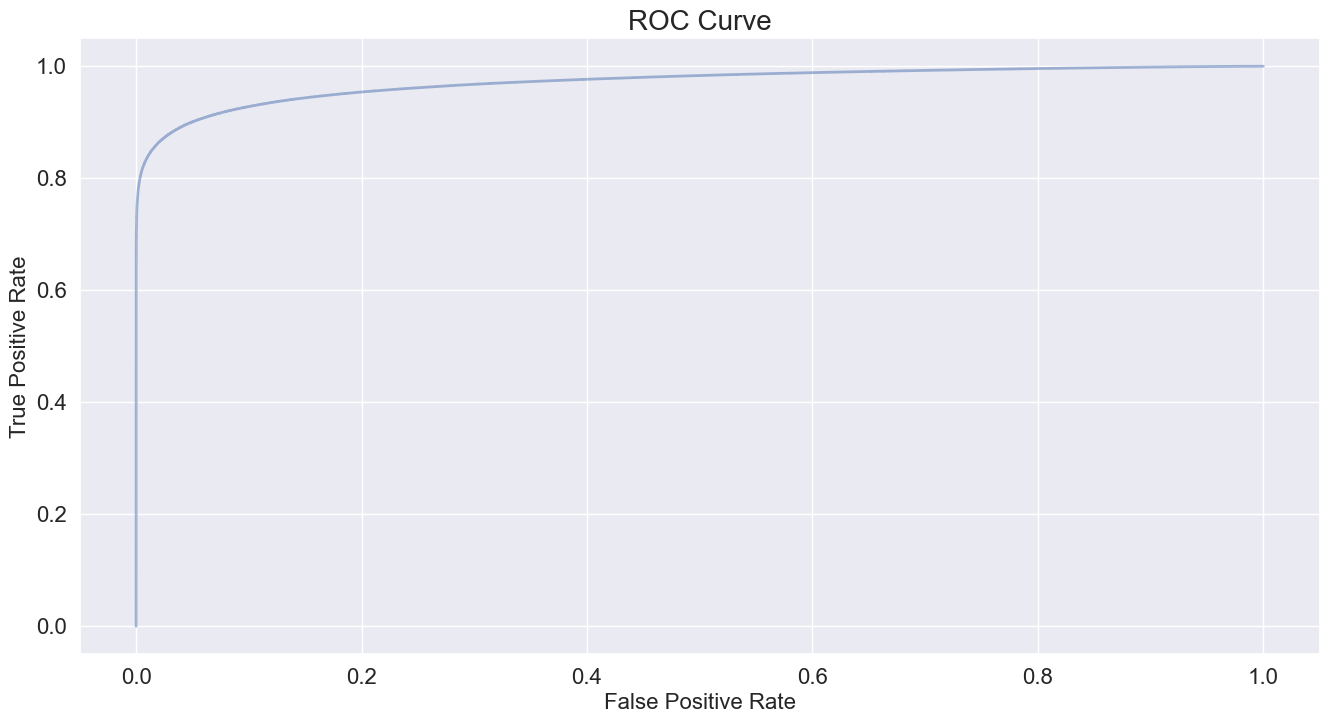

In [74]:
# построение кривой ROC AUC

get_roc_curve(model_clf, test_data, plot=True);

### Кросс-валидация

In [75]:
parameters = {
             'cat_features': cat_features,
             'eval_metric': 'F1',
             'loss_function': 'Logloss',
             'task_type': 'GPU',
             'random_seed': 42,
             'verbose': 100
              }

In [76]:
train_data = Pool(train[X],
                  label=train[y],
                  cat_features=cat_features)

In [77]:
cv_data = cv(
    params = parameters,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]
bestTest = 0.9136585591
bestIteration = 999
Training on fold [1/5]
bestTest = 0.9117407372
bestIteration = 999
Training on fold [2/5]
bestTest = 0.9120228729
bestIteration = 995
Training on fold [3/5]
bestTest = 0.9109416182
bestIteration = 998
Training on fold [4/5]
bestTest = 0.913663756
bestIteration = 998


In [78]:
cv_data

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.789610,0.000464,0.789610,0.000116,0.666753,0.000036,0.666753,0.000052
1,1,0.839286,0.000290,0.839288,0.000078,0.640695,0.000066,0.640694,0.000095
2,2,0.840026,0.001513,0.840048,0.001592,0.618983,0.000141,0.618982,0.000156
3,3,0.840484,0.000299,0.840484,0.000075,0.598800,0.000126,0.598799,0.000165
4,4,0.834632,0.003371,0.834657,0.003158,0.579702,0.000347,0.579700,0.000352
...,...,...,...,...,...,...,...,...,...
995,995,0.912393,0.001215,0.911722,0.001020,0.217145,0.002222,0.219122,0.001990
996,996,0.912398,0.001208,0.911727,0.001013,0.217129,0.002205,0.219108,0.001974
997,997,0.912397,0.001209,0.911727,0.001011,0.217126,0.002205,0.219105,0.001974
998,998,0.912400,0.001212,0.911728,0.001013,0.217120,0.002205,0.219101,0.001975


In [79]:
cv_data[cv_data['test-F1-mean'] == cv_data['test-F1-mean'].max()]

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
999,999,0.912404,0.001214,0.911731,0.001014,0.217116,0.002207,0.219098,0.001977


In [80]:
n_iters = cv_data[cv_data['test-F1-mean'] == cv_data['test-F1-mean'].max()]['iterations'].values[0]

n_iters

999

In [81]:
parameters = {
             'iterations':n_iters,         
             'cat_features': cat_features,
             'eval_metric': 'F1',
             'loss_function': 'Logloss',
             'task_type': 'GPU',
             'random_seed': 42,
             'verbose': 100
              }

In [82]:
model_clf_cv = CatBoostClassifier(**parameters)

In [83]:
model_clf_cv.fit(train_data, eval_set=(val[X], val[y]))

Learning rate set to 0.034106
0:	learn: 0.7896103	test: 0.7897767	best: 0.7897767 (0)	total: 913ms	remaining: 15m 11s
100:	learn: 0.8870477	test: 0.8868339	best: 0.8868339 (100)	total: 1m 26s	remaining: 12m 49s
200:	learn: 0.8973518	test: 0.8972697	best: 0.8972697 (200)	total: 2m 56s	remaining: 11m 39s
300:	learn: 0.9037620	test: 0.9038192	best: 0.9038247 (299)	total: 4m 27s	remaining: 10m 21s
400:	learn: 0.9077045	test: 0.9078887	best: 0.9078887 (400)	total: 5m 56s	remaining: 8m 51s
500:	learn: 0.9109211	test: 0.9111448	best: 0.9111448 (500)	total: 7m 27s	remaining: 7m 24s
600:	learn: 0.9137589	test: 0.9142286	best: 0.9142286 (600)	total: 8m 57s	remaining: 5m 56s
700:	learn: 0.9158270	test: 0.9164297	best: 0.9164297 (700)	total: 10m 29s	remaining: 4m 27s
800:	learn: 0.9176225	test: 0.9182573	best: 0.9182573 (800)	total: 11m 59s	remaining: 2m 57s
900:	learn: 0.9192480	test: 0.9199708	best: 0.9199708 (900)	total: 13m 27s	remaining: 1m 27s
998:	learn: 0.9204677	test: 0.9212427	best: 0.92

In [84]:
# прогноз количества дней для метрики

test['pred_cv_buy_post'] = model_clf_cv.predict(test[X])

In [85]:
# метрика F1 после кросс-валидации

f1_score(test['buy_post'], test['pred_cv_buy_post'])

0.9215710488174239

Наблюдаю небольшой рост метрики после кросс-валидации

### Работа с тестовым датасетом

Ссылка на test:

https://drive.google.com/file/d/19ceSQZW0mrXGMF4Aer9DGVLK3wsU0sKY/view?usp=sharing


In [86]:
# # для запуска в colab

# !gdown 19ceSQZW0mrXGMF4Aer9DGVLK3wsU0sKY

In [87]:
# # для запуска в colab

# !unzip -o '/content/hackaton2023_test.zip'

In [88]:
test_df = pd.read_parquet('hackaton2023_test.parquet')

In [89]:
test_df.head()

,customer_id,group_name,revenue,startdatetime,dish_name,ownareaall_sqm,format_name
1773606,13220760,test,0.28,2022-12-22 13:09:11,"Липтон Лимон в бутылке 0,5л",174.4,Фудкорт с туалетом
4035564,30315975,test,139.99,2023-03-05 16:45:05,Пиво Балтика 7 0.5л розлив,235.0,Отдельно стоящий
2507770,21679985,test,36.00,2022-12-13 16:10:55,Кинг Фри мал,165.0,Фудкорт без туалета
3963775,29754274,test,230.00,2023-03-14 14:10:43,Цезарь ролл со стрипсами,150.0,Фудкорт без туалета
859943,7797823,test,204.96,2022-10-22 14:09:28,Up Гранд Чиз Фреш,114.5,Фудкорт без туалета


In [90]:
len(test_df)

2498034

In [91]:
test_df.drop('group_name', axis=1, inplace=True)

In [92]:
# feature generation

counts = test_df['customer_id'].value_counts()
test_df['loyality'] = test_df['customer_id'].apply(lambda x: counts.loc[x])

test_df['datetime'] = pd.to_datetime(test_df['startdatetime'], format='mixed')
test_df['day_of_week'] = test_df['datetime'].dt.dayofweek
test_df['hour_of_day'] = test_df['datetime'].dt.hour
test_df['month'] = test_df['datetime'].dt.month
test_df['quarter'] = test_df['datetime'].dt.quarter

category_counts = test_df['dish_name'].value_counts()
threshold = category_counts.median()
for i in range(len(category_counts)):
    if category_counts[i] < threshold:
        test_df['dish_name'].replace(category_counts.index[i], 'Другое', inplace=True)
len(test_df['dish_name'].value_counts())

test_df['ownareaall_sqm'] = test_df['ownareaall_sqm'].apply(fit_area)

In [93]:
X = ['revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter']

In [94]:
# предсказание количества дней до следующей покупки

test_df['date_diff_post'] = model_rgr.predict(test_df[X])

In [95]:
test_df['date_diff_post'] = test_df['date_diff_post'].round().astype(int)

In [96]:
X = ['date_diff_post', 'revenue', 'dish_name', 'ownareaall_sqm', 'format_name', 
     'loyality', 'day_of_week', 'hour_of_day', 'month', 'quarter']

In [97]:
# предсказание оттока посетителей

test_df['buy_post'] = model_clf_cv.predict(test_df[X])

In [98]:
test_df

,customer_id,revenue,startdatetime,dish_name,ownareaall_sqm,format_name,loyality,datetime,day_of_week,hour_of_day,month,quarter,date_diff_post,buy_post
1773606,13220760,0.28,2022-12-22 13:09:11,"Липтон Лимон в бутылке 0,5л",1,Фудкорт с туалетом,63,2022-12-22 13:09:11,3,13,12,4,12,0
4035564,30315975,139.99,2023-03-05 16:45:05,Пиво Балтика 7 0.5л розлив,2,Отдельно стоящий,8,2023-03-05 16:45:05,6,16,3,1,27,0
2507770,21679985,36.00,2022-12-13 16:10:55,Кинг Фри мал,1,Фудкорт без туалета,38,2022-12-13 16:10:55,1,16,12,4,17,0
3963775,29754274,230.00,2023-03-14 14:10:43,Цезарь ролл со стрипсами,1,Фудкорт без туалета,19,2023-03-14 14:10:43,1,14,3,1,20,0
859943,7797823,204.96,2022-10-22 14:09:28,Up Гранд Чиз Фреш,1,Фудкорт без туалета,85,2022-10-22 14:09:28,5,14,10,4,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677742,12727388,99.99,2023-04-29 10:12:21,Сырные Медальоны (6 шт.),0,Фудкорт без туалета,53,2023-04-29 10:12:21,5,10,4,2,8,0
4450230,36332632,79.98,2023-02-12 19:57:23,"Липтон Грин Дж 0,3",2,Отдельно стоящий без внешней зоны,78,2023-02-12 19:57:23,6,19,2,1,7,0
3882998,29278039,209.99,2022-11-08 15:39:53,Воппер Ролл,2,Отдельно стоящий с внешней зоной,204,2022-11-08 15:39:53,1,15,11,4,2,0
1356999,11223378,679.98,2023-01-31 19:15:39,Двойной Воппер с сыром,1,Фудкорт без туалета,24,2023-01-31 19:15:39,1,19,1,1,19,0


Эти данные можно будет использовать для формирования сабмишенов.